In [ ]:
m# loading libraries for data manipulation
import numpy as np
import pandas as pd

# loading libraries for data visualization
import matplotlib.pyplot as plt
from pathlib import Path

# import tensorflow and keras packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import MobileNetV2

# import PCA and tSNE for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix

# import kagglehub library to fetch data
import kagglehub

# import os and glob for file directory operations
import os, glob

import warnings
warnings.filterwarnings('ignore')

## Data Loading and Preprocessing

In [ ]:
# download dataset
path = kagglehub.dataset_download("techsash/waste-classification-data")
print("Path to dataset files:", path)

100%|██████████| 427M/427M [00:01<00:00, 275MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


In [ ]:
# set paths to training and test data
train_data = Path(path) / 'dataset' / 'DATASET' / 'TRAIN'
test_data = Path(path) / 'dataset' / 'DATASET' / 'TEST'

print(f"Training data path: {train_data}")
print(f"Test data path: {test_data}")

Training data path: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/dataset/DATASET/TRAIN
Test data path: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/dataset/DATASET/TEST


In [ ]:
# parameters
img_size = 224
batch_size = 32
num_classes = 2

In [ ]:
# data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,              # normalize pixel values to [0, 1]
    rotation_range=20,           # random rotations up to 20 degrees
    width_shift_range=0.2,       # random horizontal shifts
    height_shift_range=0.2,      # random vertical shifts
    brightness_range=[0.8, 1.2], # random brightness adjustments
    shear_range=0.2,             # shear transformations
    zoom_range=0.2,              # random zoom
    horizontal_flip=True,        # random horizontal flips
    fill_mode='nearest',         # fill strategy for new pixels
    validation_split=0.2         # 80/20 train/val split
)

# validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# data generators
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    train_data,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

#rename the class indices to organic and recyclable
train_generator.class_indices = {'organic': 0, 'recyclable': 1}
print(f"\nClass indices: {train_generator.class_indices}")


Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.

Class indices: {'organic': 0, 'recyclable': 1}


In [ ]:
# visualize sample images
images, labels = next(train_generator)
class_labels = list(train_generator.class_indices.keys())

n = 10
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].argmax()])
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.tight_layout()
plt.show()
print(class_labels)

['organic', 'recyclable']


## Part 1: CNN Model

We will design and train a CNN from scratch to perform binary classification (organic vs recyclable).

In [ ]:
# CNN
model = keras.models.Sequential([
    # Conv Block 1
    layers.Conv2D(32, (3, 3),activation='relu',strides=(2, 2),input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2, 2),strides=(2, 2)),
    layers.BatchNormalization(),
    # Conv Block 2
    layers.Conv2D(64, (3, 3),strides=(2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2),strides=(2, 2)),
    layers.BatchNormalization(),
    # Conv Block 3
    layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2),strides=(1,1)),
    layers.BatchNormalization(),
    # Dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 55, 55, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,734,082 (6.61 MB)

 Trainable params: 1,733,634 (6.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# compile the model
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
# training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 118s 206ms/step - accuracy: 0.7898 - loss: 0.6518 - val_accuracy: 0.7442 - val_loss: 0.5139
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 108s 191ms/step - accuracy: 0.8304 - loss: 0.4063 - val_accuracy: 0.8240 - val_loss: 0.4333
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 106s 188ms/step - accuracy: 0.8375 - loss: 0.3933 - val_accuracy: 0.7812 - val_loss: 0.5097
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 111s 196ms/step - accuracy: 0.8438 - loss: 0.3748 - val_accuracy: 0.6137 - val_loss: 0.8473
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 110s 194ms/step - accuracy: 0.8499 - loss: 0.3648 - val_accuracy: 0.8360 - val_loss: 0.4245
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 111s 197ms/step - accuracy: 0.8574 - loss: 0.3553 - val_accuracy: 0.8681 - val_loss: 0.3187
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 112s 199ms/step - accuracy: 0.8571 - loss: 0.3482 - val_accuracy: 0.8449 - val_loss: 0.3896
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 119s 211ms/step - accuracy: 0.8617 -

In [ ]:
history_df = pd.DataFrame(history.history)

# plot accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# evaluate
test_results = model.evaluate(test_generator, verbose=1)
print("Test Set Results:")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9065 - loss: 0.2624
Test Set Results:
Test Loss: 0.2624
Test Accuracy: 0.9065 (90.65%)


In [ ]:
# predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

print(f"\nPredictions shape: {predictions.shape}")
print(f"Number of predictions: {len(predicted_classes)}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

Predictions shape: (2513, 2)
Number of predictions: 2513


Found 2513 images belonging to 2 classes.


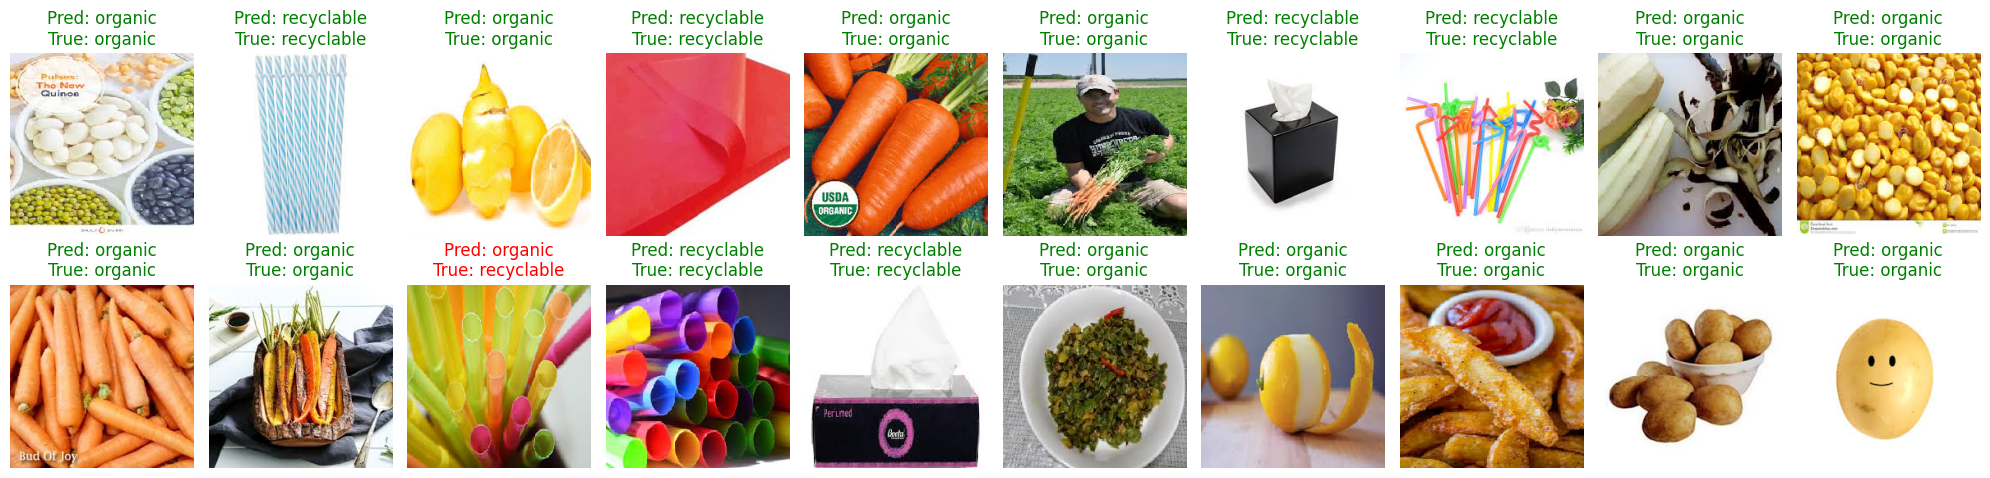

In [ ]:
# specific generator ONLY for visualization (shuffle=True)
viz_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

x_batch, y_batch = next(viz_generator)

batch_preds = model.predict(x_batch, verbose=0)
batch_pred_indices = np.argmax(batch_preds, axis=1)
batch_true_indices = np.argmax(y_batch, axis=1)

# create a map to get class names (0 -> 'organic', 1 -> 'recyclable')
label_map = {v: k for k, v in train_generator.class_indices.items()}

# 4. plot with predicted and true labels
n = 20  # Number of images to display
plt.figure(figsize=(20, 5))

for i in range(min(n, len(x_batch))):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_batch[i])

    pred_name = label_map[batch_pred_indices[i]]
    true_name = label_map[batch_true_indices[i]]

    # Title color: Green if prediction is correct, Red if wrong
    color = 'green' if pred_name == true_name else 'red'

    plt.title(f"Pred: {pred_name}\nTrue: {true_name}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# classification report for CNN
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = predictions.argmax(axis=1)
true_classes = test_generator.classes
class_indices = list(test_generator.class_indices.keys())

print("CNN Classification Report:")
print(classification_report(true_classes, predicted_classes,
                          target_names=class_indices, digits=4))

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           O     0.8961    0.9415    0.9182      1401
           R     0.9212    0.8624    0.8908      1112

    accuracy                         0.9065      2513
   macro avg     0.9086    0.9019    0.9045      2513
weighted avg     0.9072    0.9065    0.9061      2513



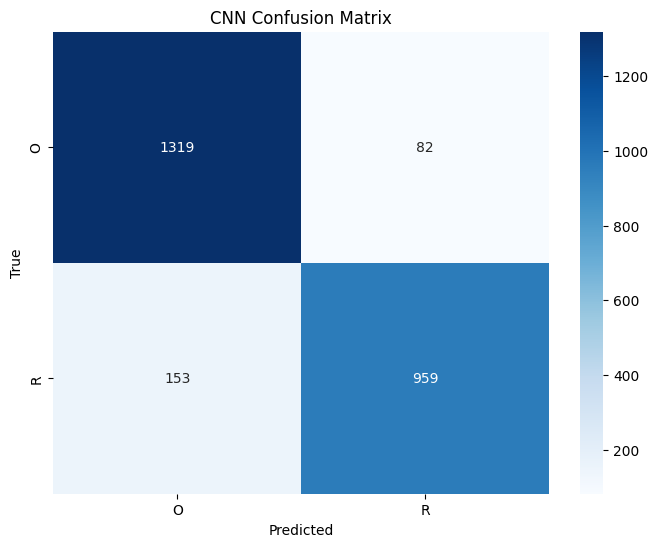

In [ ]:
# confusion matrix for CNN
import seaborn as sns
cm_cnn = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_indices,
            yticklabels=class_indices)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Part 2: Transfer Learning with MobileNetV2

We will use MobileNetV2 pretrained on ImageNet as a feature extractor, then fine-tune it for our waste classification task.

In [ ]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

# create new generators WITHOUT rescaling
transfer_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNetV2 preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

transfer_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

transfer_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
# generators for transfer learning
transfer_train_generator = transfer_train_datagen.flow_from_directory(
    train_data,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

transfer_val_generator = transfer_val_datagen.flow_from_directory(
    train_data,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

transfer_test_generator = transfer_test_datagen.flow_from_directory(
    test_data,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
# pre-trained MobileNetV2 model (without top layers)
base_model = MobileNetV2(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)

# freeze the base model weights
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# build transfer learning model
transfer_model = keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

transfer_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,578 (9.89 MB)

 Trainable params: 331,522 (1.26 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [ ]:
# compile transfer learning model
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
transfer_history_phase1 = transfer_model.fit(
    transfer_train_generator,
    validation_data=transfer_val_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 207s 361ms/step - accuracy: 0.8962 - loss: 0.2896 - val_accuracy: 0.9457 - val_loss: 0.1514
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 204s 361ms/step - accuracy: 0.9177 - loss: 0.2097 - val_accuracy: 0.9481 - val_loss: 0.1431
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 222s 393ms/step - accuracy: 0.9284 - loss: 0.1849 - val_accuracy: 0.9488 - val_loss: 0.1420
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 212s 375ms/step - accuracy: 0.9331 - loss: 0.1758 - val_accuracy: 0.9382 - val_loss: 0.1621
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 257s 454ms/step - accuracy: 0.9319 - loss: 0.1755 - val_accuracy: 0.9528 - val_loss: 0.1260
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 307s 544ms/step - accuracy: 0.9386 - loss: 0.1614 - val_accuracy: 0.9461 - val_loss: 0.1442
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 256s 452ms/step - accuracy: 0.9394 - loss: 0.1565 - val_accuracy: 0.9484 - val_loss: 0.1392
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 220s 390ms/step - accuracy: 0.9416 -

In [ ]:
# fine-tune the top layers of the base model
# unfreeze the base model
base_model.trainable = True

# freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

trainable_count = sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights])
print(f"Trainable parameters: {trainable_count:,}")


Phase 2: Fine-tuning top layers of base model...
Trainable parameters: 1,857,922


In [ ]:
# lower learning rate for fine-tuning
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks for fine-tuning
fine_tune_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
transfer_history_phase2 = transfer_model.fit(
    transfer_train_generator,
    validation_data=transfer_val_generator,
    epochs=10,
    callbacks=[fine_tune_early_stopping],
    verbose=1
)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 219s 374ms/step - accuracy: 0.9351 - loss: 0.1656 - val_accuracy: 0.9379 - val_loss: 0.1673
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 208s 368ms/step - accuracy: 0.9412 - loss: 0.1524 - val_accuracy: 0.9417 - val_loss: 0.1632
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 229s 404ms/step - accuracy: 0.9464 - loss: 0.1404 - val_accuracy: 0.9437 - val_loss: 0.1590
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 239s 423ms/step - accuracy: 0.9474 - loss: 0.1380 - val_accuracy: 0.9430 - val_loss: 0.1555
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 246s 435ms/step - accuracy: 0.9500 - loss: 0.1298 - val_accuracy: 0.9455 - val_loss: 0.1497
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 242s 428ms/step - accuracy: 0.9510 - loss: 0.1251 - val_accuracy: 0.9466 - val_loss: 0.1465
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 255s 451ms/step - accuracy: 0.9513 - loss: 0.1224 - val_accuracy: 0.9486 - val_loss: 0.1434
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 281s 497ms/step - accuracy: 0.9596 -

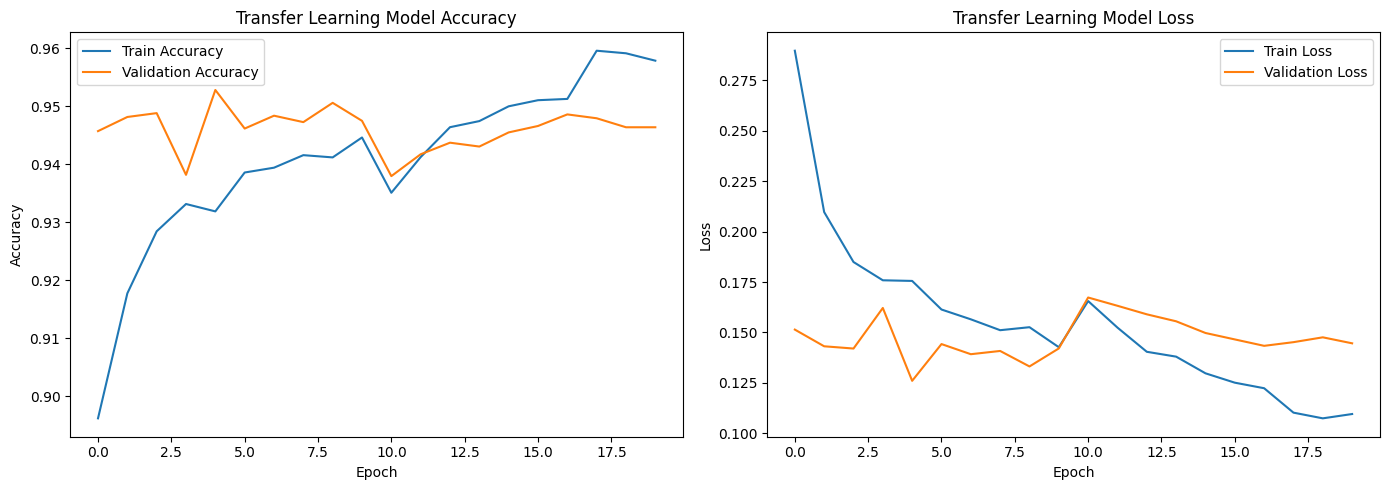

In [ ]:
# combine histories from both phases
acc = transfer_history_phase1.history['accuracy'] + transfer_history_phase2.history['accuracy']
val_acc = transfer_history_phase1.history['val_accuracy'] + transfer_history_phase2.history['val_accuracy']
loss = transfer_history_phase1.history['loss'] + transfer_history_phase2.history['loss']
val_loss = transfer_history_phase1.history['val_loss'] + transfer_history_phase2.history['val_loss']

# plot combined history
plt.figure(figsize=(14, 5))

# plot accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Transfer Learning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# evaluate transfer learning model on test set
transfer_test_generator.reset()
transfer_test_results = transfer_model.evaluate(transfer_test_generator, verbose=1)

print(f"\nTransfer Learning Model - Test Results:")
print(f"Test Loss: {transfer_test_results[0]:.4f}")
print(f"Test Accuracy: {transfer_test_results[1]:.4f} ({transfer_test_results[1]*100:.2f}%)")

79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 221ms/step - accuracy: 0.8854 - loss: 0.2752

Transfer Learning Model - Test Results:
Test Loss: 0.2752
Test Accuracy: 0.8854 (88.54%)


In [ ]:
# classification report for transfer learning model
transfer_test_generator.reset()
transfer_predictions = transfer_model.predict(transfer_test_generator)
transfer_predicted_classes = transfer_predictions.argmax(axis=1)
transfer_true_classes = transfer_test_generator.classes

print("Transfer Learning Classification Report:")
print(classification_report(transfer_true_classes, transfer_predicted_classes,
                          target_names=class_indices, digits=4))

79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step
Transfer Learning Classification Report:
              precision    recall  f1-score   support

           O     0.8400    0.9814    0.9052      1401
           R     0.9703    0.7644    0.8551      1112

    accuracy                         0.8854      2513
   macro avg     0.9051    0.8729    0.8802      2513
weighted avg     0.8976    0.8854    0.8830      2513



## Model Comparison

In [ ]:
# compare both models
print("Model Comparison on Test Set")
print(f"{'Model':<25} {'Accuracy':<15} {'Loss':<15}")
print(f"{'CNN':<25} {test_results[1]*100:.2f}%{'':<8} {test_results[0]:.4f}")
print(f"{'Transfer Learning':<25} {transfer_test_results[1]*100:.2f}%{'':<8} {transfer_test_results[0]:.4f}")

Model Comparison on Test Set
Model                     Accuracy        Loss           
CNN                       90.65%         0.2624
Transfer Learning         88.54%         0.2752


## Part 3: Convolutional Autoencoder

We will build a convolutional autoencoder to learn compressed latent representations of waste images. These embeddings will be clustered to explore how the network groups similar waste types.

In [ ]:
LATENT_DIM = 512
ae_img_size = 128

In [ ]:
# data generators for autoencoder
ae_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

ae_test_datagen = ImageDataGenerator(
    rescale=1./255
)

ae_train_generator = ae_datagen.flow_from_directory(
    train_data,
    target_size=(ae_img_size, ae_img_size),
    batch_size=batch_size,
    class_mode='input',
    subset='training',
    shuffle=True
)

ae_val_generator = ae_datagen.flow_from_directory(
    train_data,
    target_size=(ae_img_size, ae_img_size),
    batch_size=batch_size,
    class_mode='input',
    subset='validation',
    shuffle=False
)

ae_test_generator = ae_test_datagen.flow_from_directory(
    test_data,
    target_size=(ae_img_size, ae_img_size),
    batch_size=batch_size,
    class_mode='input',
    shuffle=False
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
#encoder
encoder_inputs = keras.Input(shape=(ae_img_size, ae_img_size, 3))
x = layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
latent = layers.Dense(LATENT_DIM, name="latent_vector")(x)

encoder = keras.Model(encoder_inputs, latent, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 512)            │    16,777,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,871,872 (64.36 MB)

 Trainable params: 16,871,424 (64.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# decoder
decoder_inputs = keras.Input(shape=(LATENT_DIM,))
x = layers.Dense(16 * 16 * 128, activation="relu")(decoder_inputs)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)

decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32768)          │    16,809,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,051,587 (65.05 MB)

 Trainable params: 17,051,139 (65.04 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
autoencoder = keras.Model(encoder_inputs,
                          decoder(encoder(encoder_inputs)),
                          name="autoencoder"
                          )

autoencoder.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='mse'
)

ae_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
ae_history = autoencoder.fit(
    ae_train_generator,
    validation_data=ae_val_generator,
    epochs=10,
    callbacks=[ae_early_stopping],
    verbose=1
)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - loss: 0.0541 - val_loss: 0.0310
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 0.0279 - val_loss: 0.0248
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 0.0232 - val_loss: 0.0191
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 0.0197 - val_loss: 0.0184
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0180 - val_loss: 0.0170
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 0.0168 - val_loss: 0.0155
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 0.0160 - val_loss: 0.0150
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.0155 - val_loss: 0.0141
Epoch 9/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.0149 - val_loss: 0.0138
Epoch 10/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 0.0141 - val_loss: 0.0136


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


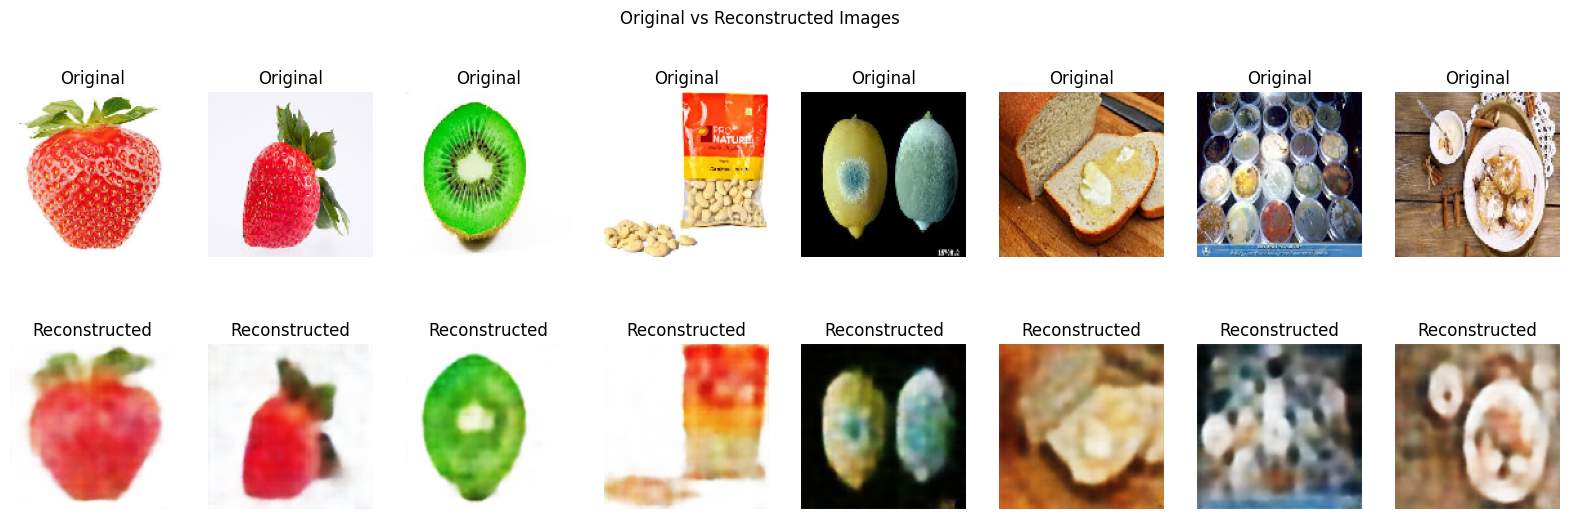

In [ ]:
ae_val_generator.reset()
sample_images = next(ae_val_generator)[0][:8]
reconstructed_images = autoencoder.predict(sample_images)

n = 8
plt.figure(figsize=(20, 6))
for i in range(n):
    # original
    plt.subplot(2, n, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis("off")

    # reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.suptitle('Original vs Reconstructed Images')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


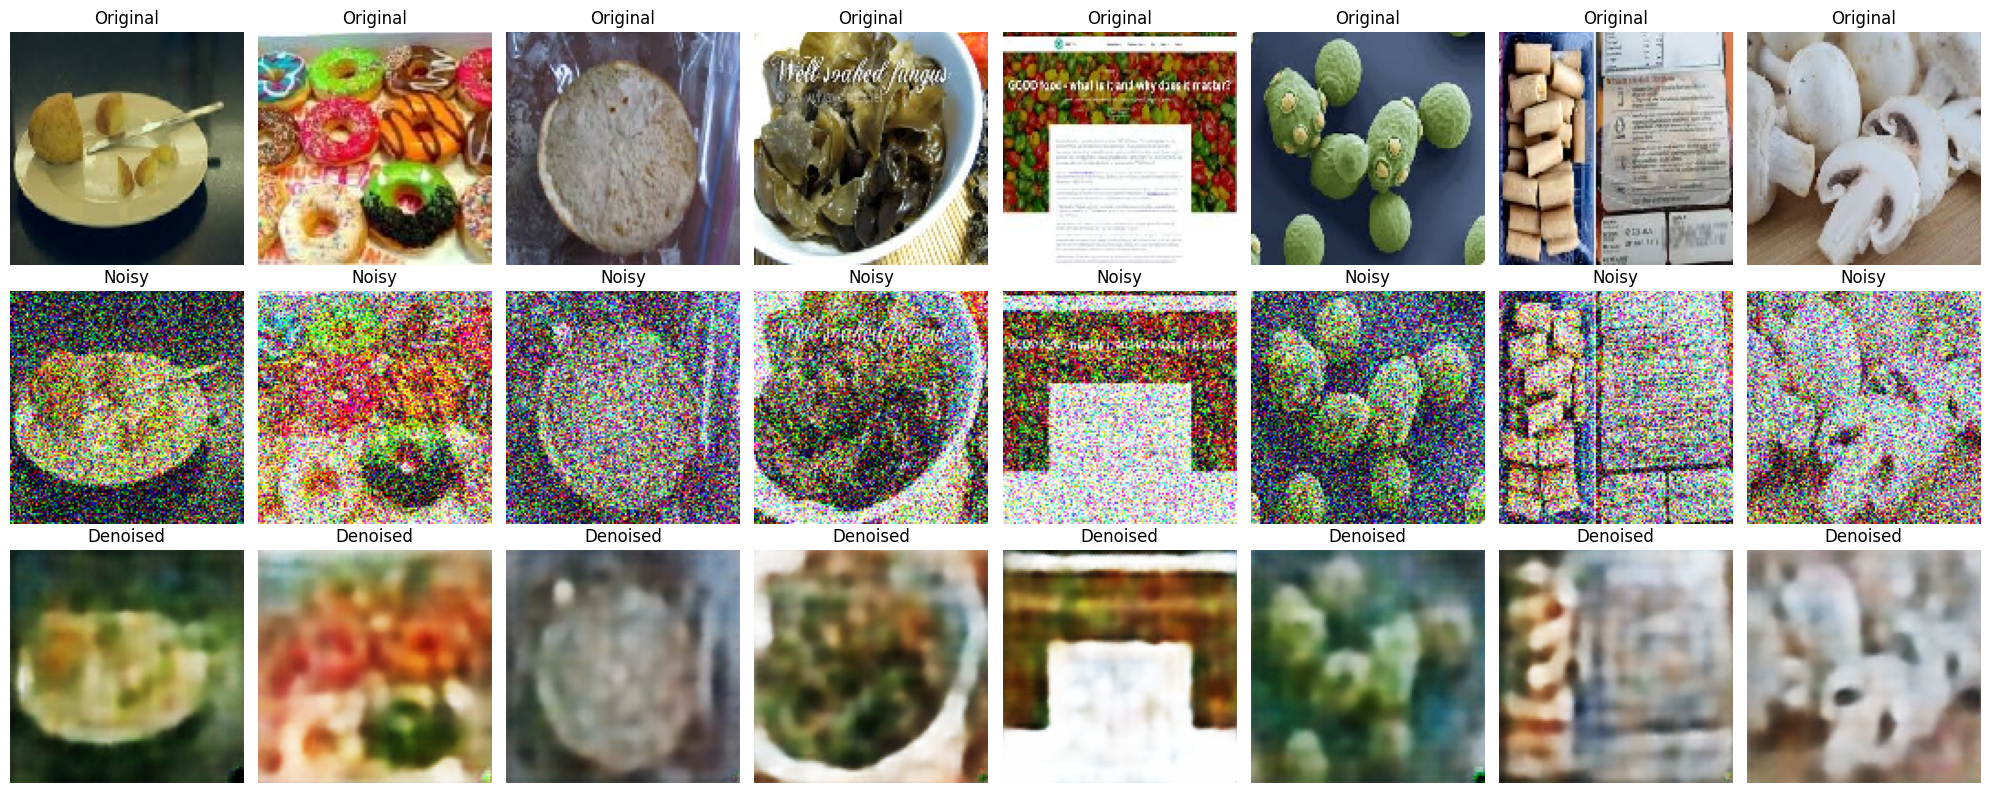

In [ ]:
sample_images, _ = next(ae_val_generator)

# Define noise as a random array with the same shape as sample_images
noise = np.random.normal(loc=0.0, scale=0.4, size=sample_images.shape)

noisy_images = sample_images + noise  # however you created noise
reconstructed_images = autoencoder.predict(noisy_images)

n = 8
plt.figure(figsize=(20, 8))

for i in range(n):

    # -------- 1. Original Clean --------
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis("off")

    # -------- 2. Noisy Input --------
    ax = plt.subplot(3, n, n + i + 1)
    plt.imshow(noisy_images[i].clip(0., 1.))
    plt.title("Noisy")
    plt.axis("off")

    # -------- 3. Denoised Output --------
    ax = plt.subplot(3, n, 2*n + i + 1)
    plt.imshow(reconstructed_images[i])
    plt.title("Denoised")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Latent Space Analysis and Clustering

In [ ]:
# extract latent embeddings for all test images
ae_test_generator.reset()

all_images = []
all_labels = []

test_label_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_data,
    target_size=(ae_img_size, ae_img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# collect all test data
for i in range(len(test_label_gen)):
    batch_images, batch_labels = test_label_gen[i]
    all_images.append(batch_images)
    all_labels.append(batch_labels.argmax(axis=1))

all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(f"Total test images: {len(all_images)}")
print(f"Labels shape: {all_labels.shape}")

Found 2513 images belonging to 2 classes.
Total test images: 2513
Labels shape: (2513,)


In [ ]:
# latent embeddings using the encoder
embeddings = encoder.predict(all_images, verbose=1)
print(f"Embeddings shape: {embeddings.shape}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Embeddings shape: (2513, 512)


In [ ]:
class_names = list(test_label_gen.class_indices.keys())
# apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# plot t-SNE visualization
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                      c=all_labels, cmap='coolwarm', alpha=0.5, s=10)
plt.colorbar(scatter, ticks=range(len(class_names)), label='Class').ax.set_yticklabels(class_names)
plt.title('t-SNE Visualization of Autoencoder Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')


handles = [plt.scatter([], [], c=plt.cm.coolwarm(i/1), label=class_names[i]) for i in range(2)]
plt.legend(handles=handles, title='Waste Type')
plt.show()

In [ ]:
# PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# PCA visualization
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1],
                      c=all_labels, cmap='coolwarm', alpha=0.5, s=10)
plt.colorbar(scatter, ticks=range(len(class_names)), label='Class').ax.set_yticklabels(class_names)
plt.title('PCA Visualization of Autoencoder Latent Space')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')

handles = [plt.scatter([], [], c=plt.cm.coolwarm(i/1), label=class_names[i]) for i in range(2)]
plt.legend(handles=handles, title='Waste Type')
plt.show()

Explained variance ratio: [0.26673716 0.05686942]
Total variance explained: 32.36%


In [ ]:
# K-Means clustering on latent embeddings
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Compare clusters with actual labels
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(all_labels, cluster_labels)
nmi = normalized_mutual_info_score(all_labels, cluster_labels)

print(f"Clustering Quality Metrics:")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")

Clustering Quality Metrics:
Adjusted Rand Index: 0.1589
Normalized Mutual Information: 0.1147


In [ ]:
plt.figure(figsize=(16, 6))

# true labels
plt.subplot(1, 2, 1)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
            c=all_labels, cmap='coolwarm', alpha=0.5, s=10)
plt.title('t-SNE: True Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# K-Means clusters
plt.subplot(1, 2, 2)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
            c=cluster_labels, cmap='viridis', alpha=0.5, s=10)
plt.title('t-SNE: K-Means Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()

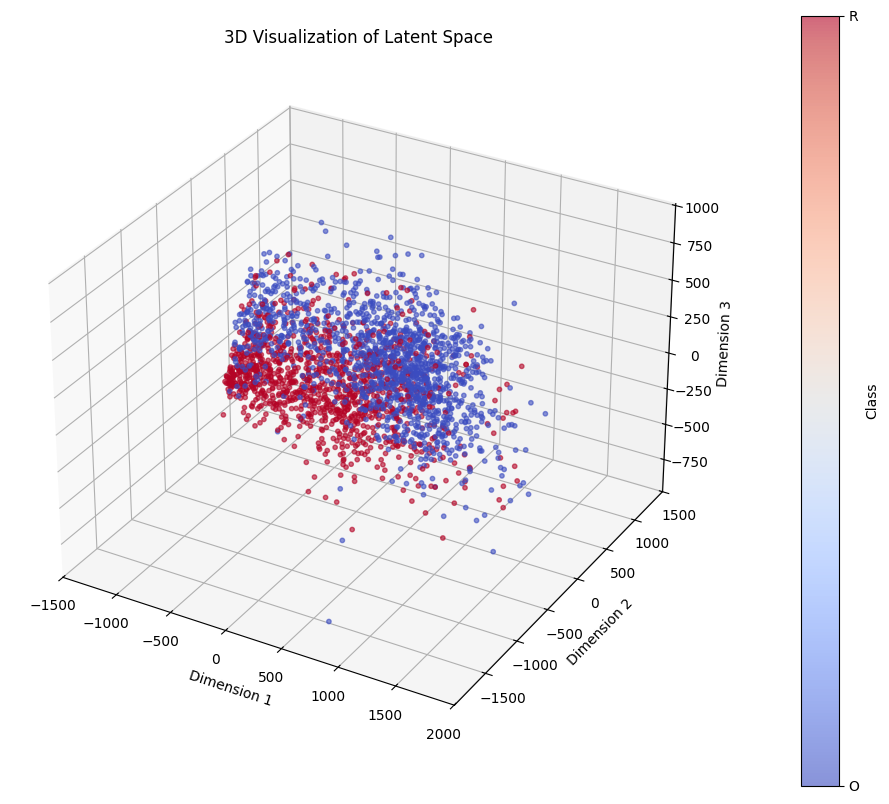

In [ ]:
# 3D visualization
pca_3d = PCA(n_components=3)
embeddings_3d = pca_3d.fit_transform(embeddings)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],
    c=all_labels, cmap='coolwarm', s=10, alpha=0.6
)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title("3D Visualization of Latent Space")

cbar = plt.colorbar(scatter, ticks=range(len(class_names)), pad=0.1)
cbar.ax.set_yticklabels(class_names)
cbar.set_label('Class')

plt.show()

In [ ]:
# confusion matrix between clusters and true labels
import seaborn as sns
cm = confusion_matrix(all_labels, cluster_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=class_names)
plt.title('Confusion Matrix: True Labels vs K-Means Clusters')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.show()

## Summary and Conclusions

In [ ]:
print("FINAL PROJECT SUMMARY")

print("\n1. CLASSIFICATION MODELS:")
print(f"   Custom CNN Test Accuracy:        {test_results[1]*100:.2f}%")
print(f"   Transfer Learning Test Accuracy: {transfer_test_results[1]*100:.2f}%")

print("\n2. AUTOENCODER ANALYSIS:")
print(f"   Latent Dimension: {LATENT_DIM}")
print(f"   Final Reconstruction Loss: {ae_history.history['val_loss'][-1]:.4f}")
print(f"   K-Means Clustering ARI: {ari:.4f}")
print(f"   K-Means Clustering NMI: {nmi:.4f}")

print("\n3. KEY FINDINGS:")
if transfer_test_results[1] > test_results[1]:
    print("   - Transfer learning outperformed custom CNN")
else:
    print("   - Custom CNN performed competitively with transfer learning")
print("   - Autoencoder successfully learned meaningful representations")
print("   - Latent space shows separation between waste categories")

FINAL PROJECT SUMMARY

1. CLASSIFICATION MODELS:
   Custom CNN Test Accuracy:        90.65%
   Transfer Learning Test Accuracy: 88.54%

2. AUTOENCODER ANALYSIS:
   Latent Dimension: 512
   Final Reconstruction Loss: 0.0200
   K-Means Clustering ARI: 0.1458
   K-Means Clustering NMI: 0.1047

3. KEY FINDINGS:
   - Custom CNN performed competitively with transfer learning
   - Autoencoder successfully learned meaningful representations
   - Latent space shows separation between waste categories
